In [23]:
%pip install shap


  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/545.2 kB ? eta -:--:--
   ---------------------------------------- 545.2/545.2 kB 4.5 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)

   -------------------- ------------------- 1/2 [shap]
   -------------------- ------------------- 1/2 [shap]
   ---------------------------------------- 2/2 [shap]

Note: you may need to restart the kernel to use updated packages.


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import shap
import joblib

df = pd.read_csv("Ameshousing.csv.csv")
print(df.shape)
df.head()


(2930, 82)


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


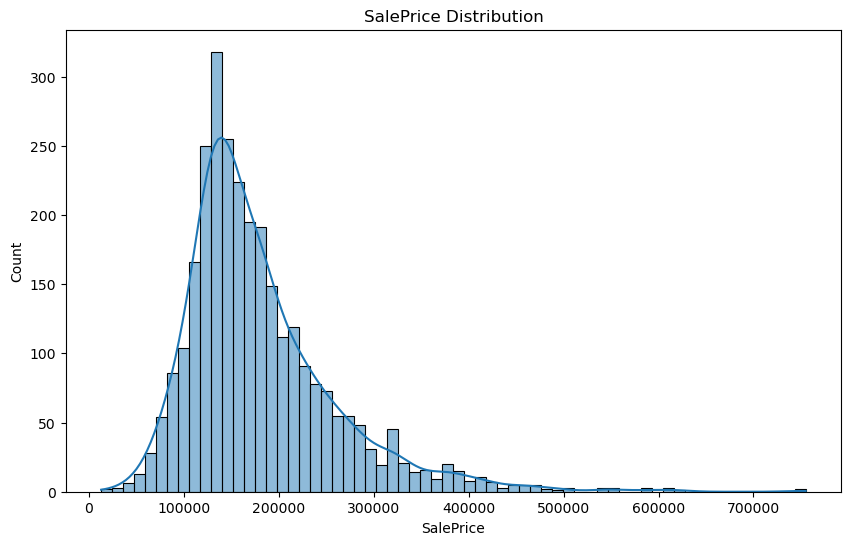

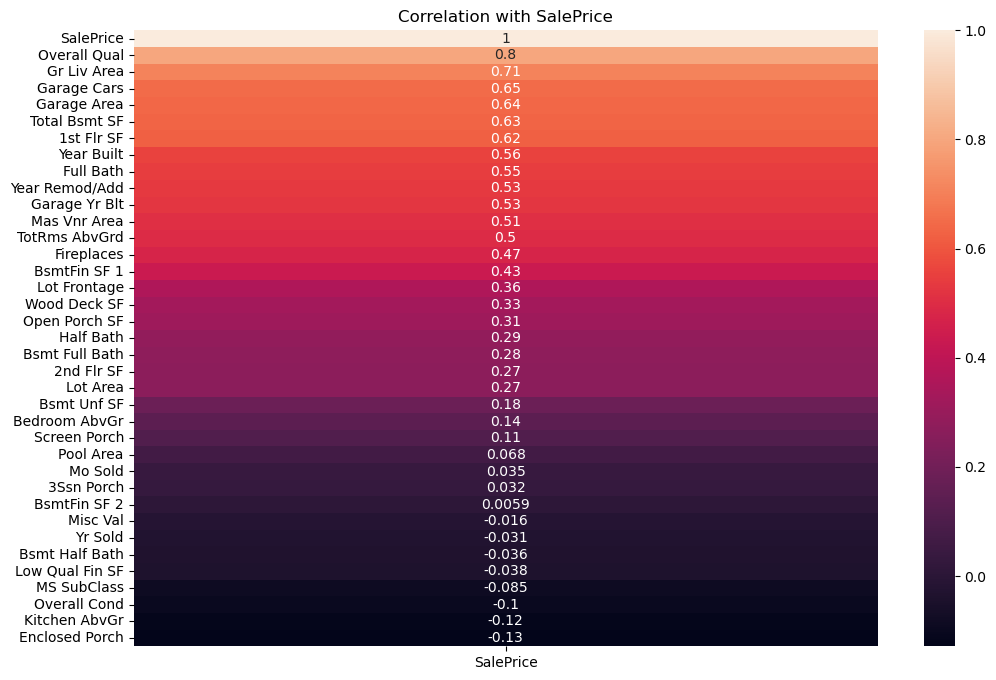

In [27]:
df.drop(['Order', 'PID'], axis=1, inplace=True)
df = df.dropna(axis=1, thresh=len(df) * 0.5)

y = df["SalePrice"]
X = df.drop("SalePrice", axis=1)

plt.figure(figsize=(10,6))
sns.histplot(y, kde=True)
plt.title("SalePrice Distribution")
plt.show()

plt.figure(figsize=(12,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True)
plt.title("Correlation with SalePrice")
plt.show()


In [29]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])


In [31]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(objective='reg:squarederror', random_state=42)
}

params = {
    "Ridge": {"model__alpha": [0.1, 1.0, 10.0]},
    "Lasso": {"model__alpha": [0.001, 0.01, 0.1]},
    "RandomForest": {"model__n_estimators": [100, 200]},
    "XGBoost": {"model__n_estimators": [100, 200], "model__learning_rate": [0.05, 0.1]}
}


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}

for name, model in models.items():
    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    
    if name in params:
        grid = GridSearchCV(pipe, param_grid=params[name], cv=5, scoring='neg_root_mean_squared_error')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
    else:
        best_model = pipe.fit(X_train, y_train)

    y_pred = best_model.predict(X_test)
    results[name] = {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": mean_squared_error(y_test, y_pred, squared=False),
        "CV Score": np.mean(cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2'))
    }


    if name == "XGBoost":
        joblib.dump(best_model, "best_xgb_model.pkl")

pd.DataFrame(results).T


C:\Users\91784\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 257399972353.4425, tolerance: 1132319147.6520543
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\91784\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 408189132739.34515, tolerance: 1081630771.4729671
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\91784\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176836748251.07288, tolerance: 1133728054.590215
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\91784\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.

,R2,MAE,RMSE,CV Score
LinearRegression,0.893209,16371.728540,29260.946224,0.851755
Ridge,0.893420,16683.911725,29232.048077,0.865693
Lasso,0.893970,16351.246908,29156.511555,0.854439
RandomForest,0.910745,15691.448404,26750.768727,0.882985
XGBoost,0.927282,14396.006379,24145.760855,0.900981


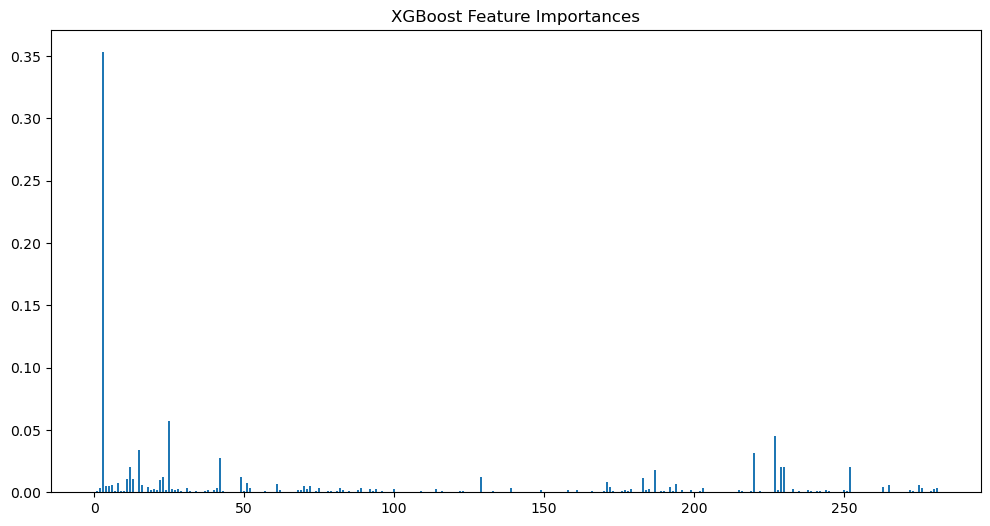

In [35]:
xgb_model = joblib.load("best_xgb_model.pkl")
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.bar(range(len(xgb_model.named_steps["model"].feature_importances_)),
        xgb_model.named_steps["model"].feature_importances_)
plt.title("XGBoost Feature Importances")
plt.show()


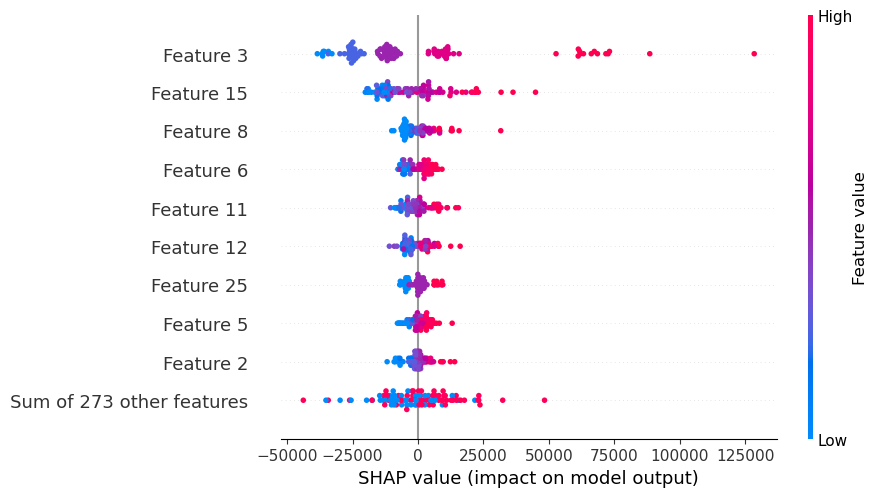

In [37]:
explainer = shap.Explainer(xgb_model.named_steps["model"])
X_transformed = preprocessor.fit_transform(X_train)
shap_values = explainer(X_transformed[:100])
shap.plots.beeswarm(shap_values)
